In [3]:
import matplotlib.pyplot as plt
import numpy as np
import os
import PIL
import tensorflow as tf

from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential

ModuleNotFoundError: No module named 'matplotlib'

The aim of this project is to build and train a model to classify flowers between 5 classes : Rose, Tulips, Sunflower, Daisy and Dondelion. We have a dataset "https://storage.googleapis.com/download.tensorflow.org/example_images/flower_photos.tgz".

# Data Exploration

Téléchargement jeu de données : 3700 photos de fleurs

In [2]:
import pathlib
dataset_url = "https://storage.googleapis.com/download.tensorflow.org/example_images/flower_photos.tgz"
data_dir = tf.keras.utils.get_file('flower_photos', origin=dataset_url, untar=True, cache_subdir = "/Users/paulcoiffet/Documents/projets infos/image_classification/data")
data_dir = pathlib.Path(data_dir)

228813984/228813984 [==============================] - 6s 0us/step


In [3]:
image_count = len(list(data_dir.glob('*/*.jpg')))
image_count

3670

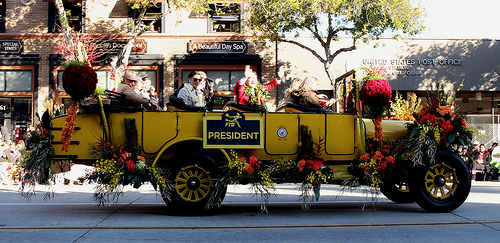

In [4]:
roses = list(data_dir.glob('roses/*'))
PIL.Image.open(str(roses[0]))

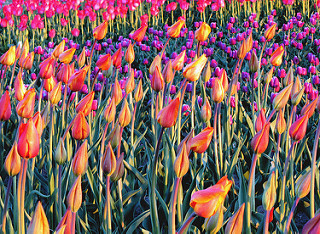

In [5]:
tulips = list(data_dir.glob('tulips/*'))
PIL.Image.open(str(tulips[0]))

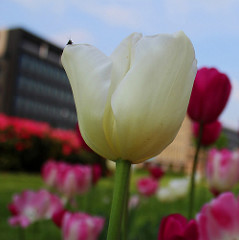

In [6]:
PIL.Image.open(str(tulips[1]))

# Data Preparation

In [8]:
batch_size = 32
img_height = 180
img_width = 180

Train dataset

In [9]:
train_ds = tf.keras.utils.image_dataset_from_directory(
  data_dir,
  validation_split=0.2,
  subset="training",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 3670 files belonging to 5 classes.
Using 2936 files for training.


Validation dataset


In [10]:
val_ds = tf.keras.utils.image_dataset_from_directory(
  data_dir,
  validation_split=0.2,
  subset="validation",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 3670 files belonging to 5 classes.
Using 734 files for validation.


In [11]:
class_names = train_ds.class_names
print(class_names)

['daisy', 'dandelion', 'roses', 'sunflowers', 'tulips']


# Data Visualisation

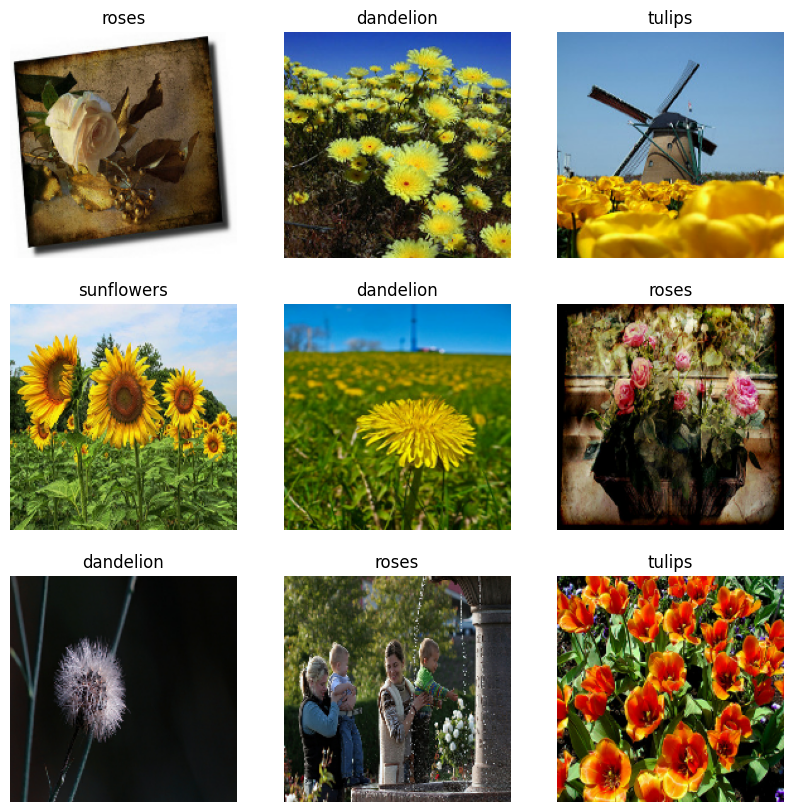

In [12]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")

In [13]:
for image_batch, labels_batch in train_ds:
  print(image_batch.shape)
  print(labels_batch.shape)
  break

(32, 180, 180, 3)
(32,)


# Standardisation and Autotune

dataset.cache() -> conserve les images en mémoire après leur chargement hors disque au cours de la première époque

dataset.prefetch() -> chevauche le pré-traitement des données et l'éxécution du modèle pendant le training

In [14]:
AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

In [15]:
normalization_layer = layers.Rescaling(1./255)

In [16]:
normalized_ds = train_ds.map(lambda x, y: (normalization_layer(x), y))
image_batch, labels_batch = next(iter(normalized_ds))
first_image = image_batch[0]

#All pixels are between 0 and 1
print(np.min(first_image), np.max(first_image))

0.0 1.0


# Modeling

We use 3 blocks of convolution with for each, a maxpool layer. ReLU Activation

In [17]:
num_classes = len(class_names)

model = Sequential([
  layers.Rescaling(1./255, input_shape=(img_height, img_width, 3)),
  layers.Conv2D(16, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Flatten(),
  layers.Dense(128, activation='relu'),
  layers.Dense(num_classes)
])

# Model Compilation

In [18]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

# Model Summary

In [19]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling_1 (Rescaling)     (None, 180, 180, 3)       0         
                                                                 
 conv2d (Conv2D)             (None, 180, 180, 16)      448       
                                                                 
 max_pooling2d (MaxPooling2  (None, 90, 90, 16)        0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 90, 90, 32)        4640      
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 45, 45, 32)        0         
 g2D)                                                            
                                                                 
 conv2d_2 (Conv2D)           (None, 45, 45, 64)        1

# Model Training

In [20]:
epochs=10
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/10
92/92 [==============================] - 14s 146ms/step - loss: 1.4044 - accuracy: 0.3937 - val_loss: 1.1070 - val_accuracy: 0.5668
Epoch 2/10
92/92 [==============================] - 13s 143ms/step - loss: 1.0493 - accuracy: 0.5766 - val_loss: 0.9941 - val_accuracy: 0.5899
Epoch 3/10
92/92 [==============================] - 13s 142ms/step - loss: 0.8737 - accuracy: 0.6625 - val_loss: 0.9168 - val_accuracy: 0.6485
Epoch 4/10
92/92 [==============================] - 13s 139ms/step - loss: 0.6902 - accuracy: 0.7398 - val_loss: 0.9490 - val_accuracy: 0.6349
Epoch 5/10
92/92 [==============================] - 13s 142ms/step - loss: 0.4760 - accuracy: 0.8249 - val_loss: 1.0710 - val_accuracy: 0.5967
Epoch 6/10
92/92 [==============================] - 13s 145ms/step - loss: 0.3132 - accuracy: 0.8941 - val_loss: 1.2091 - val_accuracy: 0.6008
Epoch 7/10
92/92 [==============================] - 13s 146ms/step - loss: 0.1817 - accuracy: 0.9390 - val_loss: 1.5137 - val_accuracy: 0.5913

# Results Visualisation

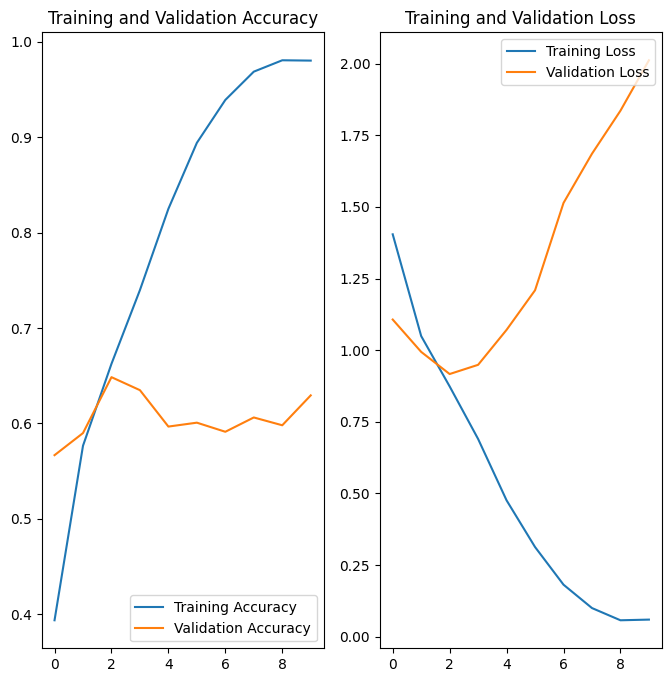

In [21]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

Only 60% accuracy which is not enough. The difference between training accuracy and validation accuracy shows that there is overfitting.

We will use data augmentation and dropout to counter this overfitting


# Data augmentation

In [22]:
data_augmentation = keras.Sequential(
  [
    layers.RandomFlip("horizontal",
                      input_shape=(img_height,
                                  img_width,
                                  3)),
    layers.RandomRotation(0.1),
    layers.RandomZoom(0.1),
  ]
)

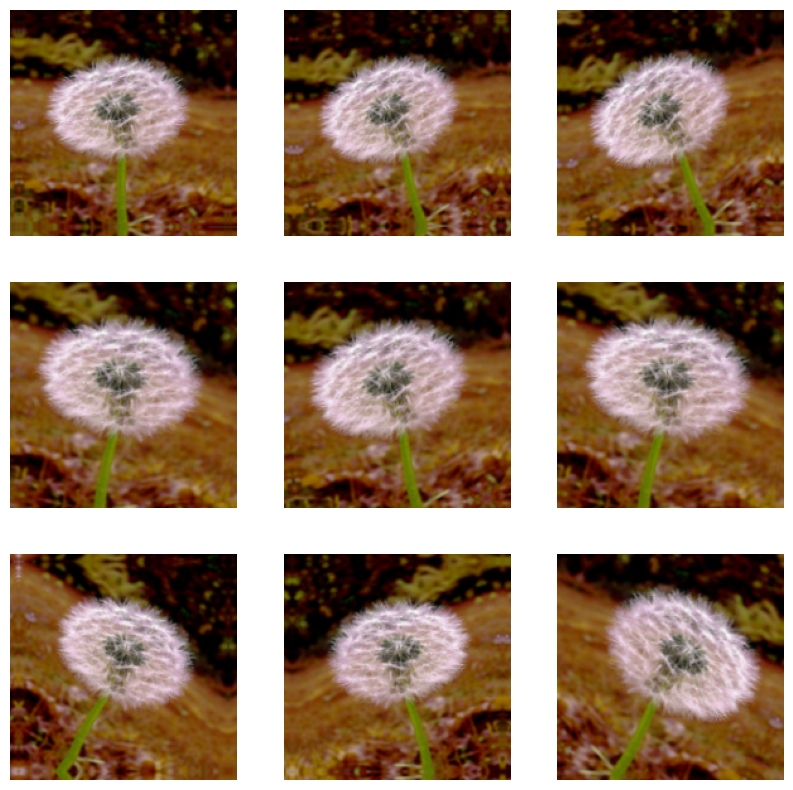

In [23]:
plt.figure(figsize=(10, 10))
for images, _ in train_ds.take(1):
  for i in range(9):
    augmented_images = data_augmentation(images)
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(augmented_images[0].numpy().astype("uint8"))
    plt.axis("off")

# Dropout


In [24]:
model = Sequential([
  data_augmentation,
  layers.Rescaling(1./255),
  layers.Conv2D(16, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Dropout(0.2),
  layers.Flatten(),
  layers.Dense(128, activation='relu'),
  layers.Dense(num_classes)
])

# New Model

In [25]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [26]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential_1 (Sequential)   (None, 180, 180, 3)       0         
                                                                 
 rescaling_2 (Rescaling)     (None, 180, 180, 3)       0         
                                                                 
 conv2d_3 (Conv2D)           (None, 180, 180, 16)      448       
                                                                 
 max_pooling2d_3 (MaxPoolin  (None, 90, 90, 16)        0         
 g2D)                                                            
                                                                 
 conv2d_4 (Conv2D)           (None, 90, 90, 32)        4640      
                                                                 
 max_pooling2d_4 (MaxPoolin  (None, 45, 45, 32)        0         
 g2D)                                                 

In [27]:
epochs = 15
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/15
92/92 [==============================] - 15s 160ms/step - loss: 1.2107 - accuracy: 0.4935 - val_loss: 1.2100 - val_accuracy: 0.5300
Epoch 2/15
92/92 [==============================] - 14s 155ms/step - loss: 0.9900 - accuracy: 0.6151 - val_loss: 1.0388 - val_accuracy: 0.5995
Epoch 3/15
92/92 [==============================] - 14s 151ms/step - loss: 0.8900 - accuracy: 0.6516 - val_loss: 0.9076 - val_accuracy: 0.6608
Epoch 4/15
92/92 [==============================] - 14s 153ms/step - loss: 0.8342 - accuracy: 0.6822 - val_loss: 0.8717 - val_accuracy: 0.6676
Epoch 5/15
92/92 [==============================] - 14s 154ms/step - loss: 0.7756 - accuracy: 0.7047 - val_loss: 0.8513 - val_accuracy: 0.6635
Epoch 6/15
92/92 [==============================] - 14s 154ms/step - loss: 0.7423 - accuracy: 0.7275 - val_loss: 0.8263 - val_accuracy: 0.6907
Epoch 7/15
92/92 [==============================] - 14s 156ms/step - loss: 0.7016 - accuracy: 0.7265 - val_loss: 0.8622 - val_accuracy: 0.6853

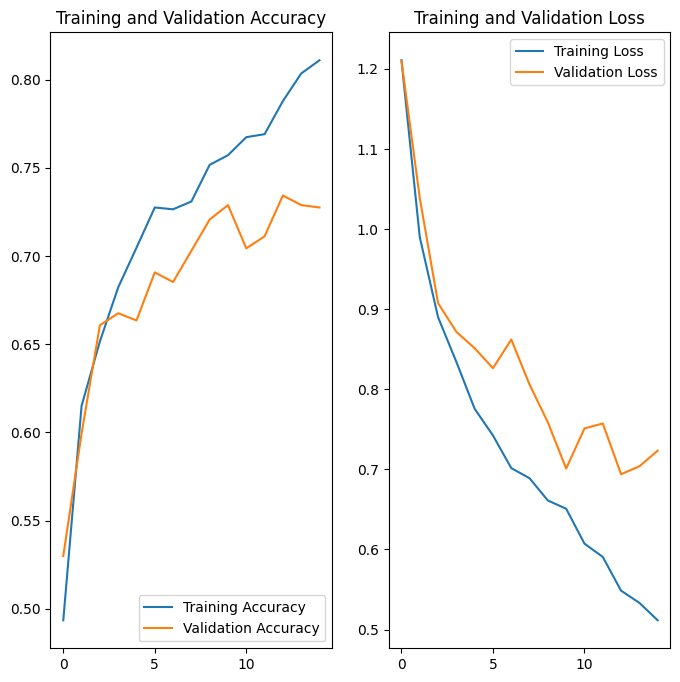

In [28]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

# Predict


In [35]:
sunflower_url = "https://storage.googleapis.com/download.tensorflow.org/example_images/592px-Red_sunflower.jpg"
sunflower_path = tf.keras.utils.get_file('Red_sunflower', origin=sunflower_url)

img = tf.keras.utils.load_img(
    sunflower_path, target_size=(img_height, img_width)
)
img_array = tf.keras.utils.img_to_array(img)
img_array = tf.expand_dims(img_array, 0) # Create a batch

predictions = model.predict(img_array)
score = tf.nn.softmax(predictions[0])

print(
    "This image most likely belongs to {} with a {:.2f} percent confidence."
    .format(class_names[np.argmax(score)], 100 * np.max(score))
)

1/1 [==============================] - 0s 14ms/step
This image most likely belongs to sunflowers with a 99.35 percent confidence.
